# Intelligent Systems - Individual Project Assessment
I aim to split the code into 3 sections:
1. Generating and analysing the datset
2. Developing my classification model
3. Training my model

In [60]:
import math
import time

import matplotlib.pyplot as plt
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np
from torchvision.transforms import Lambda
from torch.nn import functional as F
from scipy import io as sio

In [61]:
# set the selected device for the tensors
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
print(torch.cuda.get_device_name(device))
torch.set_default_device(device)

Using device: cuda
NVIDIA GeForce RTX 3050 Laptop GPU


## Dataset

### Data Augmentation
After inspection of the dataset, we have PIL images. Therefore, we will convert these to Tensors.

The values used for the normalisation of data were calculated from the ImageNet training datase

In [62]:
# We perform random transformations to better generalise the training dataset
train_transform = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    # I have chosen not to use RandomResizeCrop as it can remove large parts of the flowers
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    # These are the values I have calculated
    transforms.Normalize(mean=[0.433, 0.382, 0.296], std=[0.259, 0.209, 0.221])
])

valid_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.433, 0.382, 0.296], std=[0.259, 0.209, 0.221])
])

test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4330, 0.3819, 0.2964],std=[0.2588, 0.2094, 0.2212])
])

### Downloading and splitting the dataset

In [63]:
# I will download the data from PyTorch's website and use the appropriate data loader
train_dataset = datasets.Flowers102(
    root='flowers102',
    split="train",
    download=True,
    transform=train_transform
    # target_transform=Lambda(lambda y: F.one_hot(torch.FloatTensor(y), num_classes=102))
)

valid_dataset = datasets.Flowers102(
    root='flowers102',
    split="val",
    download=True,
    transform=valid_transform,
    target_transform=Lambda(lambda y: torch.zeros(102, dtype=torch.float).scatter_(0, torch.tensor(y), value=1))
)

test_dataset = datasets.Flowers102(
    root='flowers102',
    split="test",
    download=True,
    transform=test_transform,
    target_transform=Lambda(lambda y: torch.zeros(102, dtype=torch.float).scatter_(0, torch.tensor(y), value=1))
)

# Get the targets and ids
image_labels = sio.loadmat("flowers102/flowers-102/imagelabels")
setids = sio.loadmat("flowers102/flowers-102/setid")
print(np.unique(image_labels['labels']).size)
train_ids = setids['trnid']

102


In [64]:
image, label = train_dataset[9]
label

0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image shape: torch.Size([3, 224, 224]) -> [batch, height, width]
Datatype: torch.float32
Label: 1
Device tensor is stored on: cpu


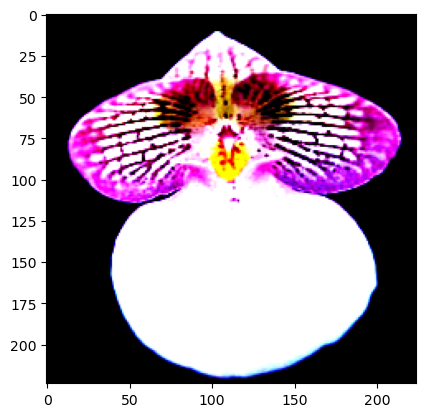

In [65]:
# look at the first training sample
image, label = train_dataset[10]
print(f"Image shape: {image.shape} -> [batch, height, width]")
print(f"Datatype: {image.dtype}")
print(f"Label: {label}")
print(f"Device tensor is stored on: {image.device}")
plt.imshow(image.permute(1, 2, 0))

## Model
I am first going to implement a very basic Convolutional Neural Network as these work well with images

In [66]:
class MyNN(nn.Module):
    def __init__(self):
        super().__init__()
        
        # Identify a lot of features
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5, stride=1)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1)
        
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.flatten = nn.Flatten(1)

        self.fc1 = nn.Linear(16 * 53 * 53, 600)
        self.fc2 = nn.Linear(600, 300)
        self.fc3 = nn.Linear(300, 102)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.pool(x)
        
        # Batch is the 1st dimension, image dimensions are 2nd and 3rd
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        return x

This architecture gave me an accuracy of 12% on the validation dataset. I will now attempt to use more channels and see if this improves the performance:

In [67]:
# Making my Convolutional Neural Network
class MyNN2(nn.Module):
    
    def __init__(self):
        super().__init__()
        
        ### Feature Learning ###
        # 3 Input channels
        self.conv1 = nn.Conv2d(3, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=2, stride=1, padding=1)
        
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.relu = nn.ReLU()
        
        # ### Classification ###
        self.flatten = nn.Flatten()
        
        # After the 3rd convolutional layer, the filters will have dimensions 26x26
        # 128 x 28 x 28 features
        self.fc1 = nn.Linear(64*28*28, 3000)
        # Classify into one of the flower categories
        self.fc2 = nn.Linear(3000, 102)
                
    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        
        x = self.conv2(x)
        x = self.relu(x)
        x = self.maxpool(x)
        
        x = self.conv3(x)
        x = self.relu(x)
        x = self.maxpool(x)
        
        # Flatten the tensor for fully connected layers        
        x = self.flatten(x)
        x = nn.Dropout(0.2)(x)
        
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)

        return x

Second Architecture was also poor (~16% accuracy). I will attempt to perform batch normalisation as well as using more convolutions per layer:

In [68]:
class MyNN3(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv1 = self.conv_layer(3, 96, 11, 4, 0)
        self.conv2 = self.conv_layer(96, 256, 5, 1, 2)
        self.conv3 = self.conv_layer(256, 512, 3, 1, 1)
        self.conv4 = self.conv_layer(512, 512, 3, 1, 1)
        self.conv5 = self.conv_layer(512, 256, 3, 1, 1)
        
        self.maxpool = nn.MaxPool2d(kernel_size = 3, stride = 2)
        self.flatten = nn.Flatten()
        
        self.fc1 = self.fully_connected(6400, 2048)
        self.fc2 = self.fully_connected(2048, 2048)
        self.fc3 = nn.Linear(2048, 102)
    
    def conv_layer(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.Conv2d(in_channels=in_channels,out_channels=out_channels, kernel_size=kernel_size, stride=stride, padding=padding),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )
    
    def fully_connected(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(in_features=in_channels, out_features=out_channels),
            nn.ReLU()
        )
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.maxpool(x)
        x = self.conv2(x)
        x = self.maxpool(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = self.maxpool(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        return x 

In [69]:
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size, shuffle=True, num_workers=0, generator=torch.Generator(device=device))

In [70]:
model1 = MyNN3().to(device)

### Loss Function

In [71]:
# Targets don't have to be one-hot encoded
# Model output (criterion input) is expected to contain un-normalised inputs
criterion = nn.CrossEntropyLoss()

### Optimiser

In [72]:
# Momentum pushes the optimiser towards the strongest gradient over multiple steps.
optimiser = optim.Adam(model1.parameters(), lr=0.001)

## Training

In [73]:
def epoch_train(model, dataloader):
    model.train()
    model.train()
    losses = []
    for idx, data in enumerate(dataloader):
        inputs, labels = data[0].to(device), data[1].to(device)
            
        optimiser.zero_grad()
        
        # Get the result as probabilities summing to 1
        logits = model(inputs)
        loss = criterion(logits.squeeze(), labels)
        
        loss.backward()
        optimiser.step()
        losses.append(loss.item())
        
        if idx % 10 == 9:
            # print(out[0])
            # print(labels[0])
            print(f"Batch {idx+1}, Loss: {loss}")
        
    return np.mean(losses), model

In [74]:
def train(model, train_loader, epochs):
    best_model = model
    best_loss = math.inf
    start_time = time.time()
    print("[INFO] Training starting...")
    losses = []
    
    for epoch in range(epochs):
        train_loss, train_model = epoch_train(model, train_loader)
        losses.append(train_loss)
        if train_loss < best_loss:
            best_loss = train_loss
            best_model = train_model
        print(f"Epoch {epoch+1}/{epochs}, Loss: {train_loss}")

    finish_time = time.time()
    print("[INFO] Training Finished")
    print(f"Elapsed time: {math.floor((finish_time-start_time)/60)}:{math.floor((finish_time-start_time)%60)}")
    PATH = 'model.pth'
    torch.save(best_model.state_dict(), PATH)
    return losses

In [75]:
epochs = 20
losses = train(model1, train_loader, epochs)

[INFO] Training starting...
Batch 10, Loss: 5.511010646820068
Batch 20, Loss: 4.690257549285889
Batch 30, Loss: 4.535038471221924
Batch 40, Loss: 4.540600299835205
Batch 50, Loss: 4.649057865142822
Batch 60, Loss: 4.418362140655518
Epoch 1/20, Loss: 4.854046709835529
Batch 10, Loss: 4.337134838104248
Batch 20, Loss: 4.354804039001465
Batch 30, Loss: 4.33525276184082
Batch 40, Loss: 4.010735034942627
Batch 50, Loss: 4.4515180587768555
Batch 60, Loss: 4.201804161071777
Epoch 2/20, Loss: 4.352271445095539
Batch 10, Loss: 4.4294633865356445
Batch 20, Loss: 4.2036590576171875
Batch 30, Loss: 4.11044979095459
Batch 40, Loss: 4.2942280769348145
Batch 50, Loss: 3.821241617202759
Batch 60, Loss: 4.287230968475342
Epoch 3/20, Loss: 4.19778062030673
Batch 10, Loss: 3.827183723449707
Batch 20, Loss: 3.8912739753723145
Batch 30, Loss: 4.032854080200195
Batch 40, Loss: 3.8291444778442383
Batch 50, Loss: 4.300077438354492
Batch 60, Loss: 4.139986991882324
Epoch 4/20, Loss: 4.111067000776529
Batch 10,

In [76]:
valid_loader = DataLoader(valid_dataset, batch_size, shuffle=True, num_workers=0, generator=torch.Generator(device=device))

In [77]:
def evaluate(model, valid_loader):
    model.eval()
    with torch.no_grad():
        acc = .0
        for i, data in enumerate(valid_loader):
            X = data[0].to(device)
            y = data[1].to(device)

            predicted = model(X)
            
            # Check each image's prediction
            for id in range(len(X)):
                if torch.argmax(predicted[id]).detach().item() == torch.argmax(y[id]).detach().item():
                    acc += 1
    model.train()
    return acc/len(valid_loader.dataset)

In [78]:
model1.load_state_dict(torch.load('model.pth'))
valid_accuracy = evaluate(model1, valid_loader)
print(f"Model's Validation Accuracy: {valid_accuracy*100}")

Model's Validation Accuracy: 16.372549019607842


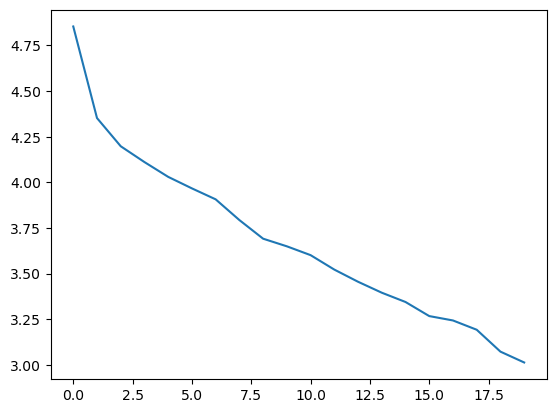

In [79]:
plt.plot(losses)